## Run this to get metrics for all of the crops

### Functions needed to match cells

In [6]:
import tifffile
import pandas as pd
import numpy as np
import os

def normalize_matrix_gt(matrix, labels, mask):
    norm_matrix = matrix.copy()
    for i, label in enumerate(labels):
        if label == 0:
            continue
        p_mask = mask == label
        norm_matrix[i,:] = matrix[i,:] / p_mask.sum()
    return norm_matrix

def normalize_matrix_pred(matrix, labels, mask):
    norm_matrix = matrix.copy()
    for i, label in enumerate(labels):
        if label == 0:
            continue
        p_mask = mask == label
        norm_matrix[:,i] = matrix[:,i] / p_mask.sum()
    return norm_matrix

def overlap_matrix_calc(ground_truth, prediction):
    # Create arrays for unique labels in the ground truth and prediction
    unique_gt_labels = np.unique(ground_truth)
    if 0 in unique_gt_labels:
        unique_gt_labels = unique_gt_labels[1:]
    unique_pred_labels = np.unique(prediction)
    if 0 in unique_pred_labels:
        unique_pred_labels = unique_pred_labels[1:]
    
    # Initialize the overlap matrix
    overlap_matrix = np.zeros((len(unique_gt_labels), len(unique_pred_labels)))
    
    # Fill in the overlap matrix with pixel counts
    for i, gt_label in enumerate(unique_gt_labels):
        if gt_label == 0:  # Skip background label
            continue
        gt_mask = ground_truth == gt_label
        for j, pred_label in enumerate(unique_pred_labels):
            if pred_label == 0:  # Skip background label
                continue
            pred_mask = prediction == pred_label
            overlap_matrix[i, j] = np.sum(np.logical_and(gt_mask, pred_mask))
    
    return overlap_matrix, unique_gt_labels, unique_pred_labels

def cell_matching(ground_truth, prediction, overlap_threshold=0.5):
    overlap_matrix, unique_gt_labels, unique_pred_labels = overlap_matrix_calc(ground_truth, prediction)

    norm_overlap_matrix_GT = normalize_matrix_gt(overlap_matrix, unique_gt_labels, ground_truth)
    norm_overlap_matrix_pred = normalize_matrix_pred(overlap_matrix, unique_pred_labels, prediction)

    ttp_perfect_match = np.where(np.logical_and(norm_overlap_matrix_pred>overlap_threshold, norm_overlap_matrix_GT>overlap_threshold))
    match_df = pd.DataFrame({'gt_label': unique_gt_labels[ttp_perfect_match[0]], 'pred_label': unique_pred_labels[ttp_perfect_match[1]]})

    ttp_gts = set(unique_gt_labels[ttp_perfect_match[0]])
    ttp_preds = set(unique_pred_labels[ttp_perfect_match[1]])

    fp_preds = set()
    fn_gts = set()

    # HANDLING OVERSEGMENTATION CASES
    oversegmentation_cases = []
    for i, gt_label in enumerate(unique_gt_labels):
        if gt_label == 0:
            continue
        overlap_matches = np.where(norm_overlap_matrix_pred[i,:]>overlap_threshold)[0]    
        # in case multiple predicted cells are matched to the same GT cell, combine them into one and add false positive counts
        if len(overlap_matches) > 1:
            for j in range(len(overlap_matches)):
                oversegmentation_cases.append((gt_label, unique_pred_labels[overlap_matches[j]]))

    # create pandas df from oversegmentation_cases tuple
    oversegmentation_df = pd.DataFrame(oversegmentation_cases, columns=['gt_label', 'pred_label'])
    oversegmentation_df_left = oversegmentation_df.copy()
    oversegmentation_df_right = pd.DataFrame(columns=['gt_label', 'pred_label'])

    # check if any second value in oversegmentation_cases is in ttp_preds. If so, replace the respective gt_label with the ttp_preds matched label
    for i, gt_label in enumerate(oversegmentation_df.gt_label):
        if oversegmentation_df.pred_label[i] in ttp_preds:

            oversegmentation_df_right = pd.concat([oversegmentation_df_right, oversegmentation_df[oversegmentation_df.gt_label == gt_label]])
            oversegmentation_df_right.loc[oversegmentation_df_right.gt_label == gt_label, 'gt_label'] = oversegmentation_df.pred_label[i]
            oversegmentation_df_left = oversegmentation_df_left[oversegmentation_df_left.gt_label != gt_label]

    for i, gt_label in enumerate(oversegmentation_df_left.gt_label.unique()):
        addition_to_df = oversegmentation_df_left[oversegmentation_df_left.gt_label == gt_label]
        pred_for_group = addition_to_df.pred_label.unique()[0]
        addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
        oversegmentation_df_right = pd.concat([oversegmentation_df_right, addition_to_df])

    fp_preds.update(set(oversegmentation_df_right.pred_label.unique()) - set(oversegmentation_df_right.gt_label.unique()))

    oversegmentation_df_left = oversegmentation_df.copy()
    for i, pred_label in enumerate(oversegmentation_df_left.pred_label):
        if pred_label in fp_preds:
            oversegmentation_df_left = oversegmentation_df_left[oversegmentation_df_left.pred_label != pred_label]

    prediction_relabel = prediction.copy()
    for i, row in oversegmentation_df_right.iterrows():
        prediction_relabel[prediction_relabel == row.pred_label] = row.gt_label

    match_df = pd.concat([match_df, oversegmentation_df_left])
    match_df = match_df.drop_duplicates()
    ttp_preds.update(set(oversegmentation_df_left.pred_label.unique()))
    ttp_gts.update(set(oversegmentation_df_left.gt_label.unique()))

    # HANDLING UNDERSEGMENTATION CASES
    undersegmentation_cases = []
    for i, pred_label in enumerate(unique_pred_labels):
        if pred_label == 0:
            continue
        overlap_matches = np.where(norm_overlap_matrix_GT[:,i]>overlap_threshold)[0]

        # in case multiple predicted cells are matched to the same GT cell, combine them into one and add false positive counts
        if len(overlap_matches) > 1:
            for j in range(len(overlap_matches)):
                undersegmentation_cases.append((unique_gt_labels[overlap_matches[j]], pred_label))

    # create pandas df from oversegmentation_cases tuple
    undersegmentation_df = pd.DataFrame(undersegmentation_cases, columns=['gt_label', 'pred_label'])
    undersegmentation_df_left = undersegmentation_df.copy()
    undersegmentation_df_right = pd.DataFrame(columns=['gt_label', 'pred_label'])

    for i, pred_label in enumerate(undersegmentation_df.pred_label):
        if undersegmentation_df.gt_label[i] in ttp_gts:
            undersegmentation_df_right = pd.concat([undersegmentation_df_right, undersegmentation_df[undersegmentation_df.pred_label == pred_label]])
            undersegmentation_df_right.loc[undersegmentation_df_right.pred_label == pred_label, 'pred_label'] = undersegmentation_df.gt_label[i]
            undersegmentation_df_left = undersegmentation_df_left[undersegmentation_df_left.pred_label != pred_label]

    for i, pred_label in enumerate(undersegmentation_df_left.pred_label.unique()):
        addition_to_df = undersegmentation_df_left[undersegmentation_df_left.pred_label == pred_label]
        gt_for_group = addition_to_df.gt_label.unique()[0]
        addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group
        undersegmentation_df_right = pd.concat([undersegmentation_df_right, addition_to_df])

    fn_gts.update(set(undersegmentation_df_right.gt_label.unique()) - set(undersegmentation_df_right.pred_label.unique()))

    undersegmentation_df_left = undersegmentation_df.copy()
    for i, gt_label in enumerate(undersegmentation_df_left.gt_label):
        if gt_label in fn_gts:
            undersegmentation_df_left = undersegmentation_df_left[undersegmentation_df_left.gt_label != gt_label]

    match_df = pd.concat([match_df, undersegmentation_df_left])
    match_df = match_df.drop_duplicates()

    ttp_preds.update(set(undersegmentation_df_left.pred_label.unique()))
    ttp_gts.update(set(undersegmentation_df_left.gt_label.unique()))

    # rename the GT to apply undersegmentation strategy (adding FN counts, but combining respective GT cells)
    ground_truth_relabel = ground_truth.copy()
    for i, row in undersegmentation_df_right.iterrows():
        initial_label, final_label = row.gt_label, row.pred_label
        ground_truth_relabel[ground_truth_relabel == initial_label] = final_label

    for label in set(unique_gt_labels) - {0} - ttp_gts:
        ground_truth_relabel[ground_truth_relabel == label] = 0

    for label in set(unique_pred_labels) - {0} - ttp_preds:
        prediction_relabel[prediction_relabel == label] = 0

    for i, row in match_df.iterrows():
        prediction_relabel[prediction_relabel == row.pred_label] = row.gt_label

    fn_gts.update(set(unique_gt_labels) - ttp_gts)
    fp_preds.update(set(unique_pred_labels) - ttp_preds)

    validate_overlap_matrix, validate_gt_labels, validate_pred_labels = overlap_matrix_calc(ground_truth_relabel, prediction_relabel)

    validate_norm_overlap_matrix_GT = normalize_matrix_gt(validate_overlap_matrix, validate_gt_labels, ground_truth_relabel)
    validate_norm_overlap_matrix_pred = normalize_matrix_pred(validate_overlap_matrix, validate_pred_labels, prediction_relabel)

    validate_ttp_perfect_match = np.where(np.logical_and(validate_norm_overlap_matrix_pred>overlap_threshold, validate_norm_overlap_matrix_GT>overlap_threshold))

    validate_match_df = pd.DataFrame({'gt_label': validate_gt_labels[validate_ttp_perfect_match[0]], 'pred_label': validate_pred_labels[validate_ttp_perfect_match[1]]})

    missing_gt_labels = set(match_df.gt_label) - set(validate_match_df.gt_label)
    missing_pred_labels = set()
    for gt_label in missing_gt_labels:
        missing_pred_labels.update(match_df[match_df.gt_label == gt_label].pred_label)
    fp_preds.update(missing_pred_labels)
    ttp_gts = ttp_gts - missing_gt_labels
    ttp_preds = ttp_preds - missing_pred_labels
    fn_gts.update(missing_gt_labels)

    final_relabel_gt = ground_truth_relabel.copy()
    for label in missing_gt_labels:
        final_relabel_gt[final_relabel_gt == label] = 0

    final_relabel_pred = prediction_relabel.copy()
    for label in missing_pred_labels:
        final_relabel_pred[final_relabel_pred == label] = 0

    total_true_positives = len(ttp_gts)
    total_false_positives = len(fp_preds)
    total_false_negatives = len(fn_gts)

    print(f'TTP preds and TTP GTs is equal? {len(ttp_gts)==len(ttp_preds)}')

    return final_relabel_gt, final_relabel_pred, total_true_positives, total_false_positives, total_false_negatives


### Run this to get the segmentation metrics (0s added for FNs and FPs)

In [7]:
GT_dir = '/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/data/annotations'
models = ['mesmer_nuclear', 'mesmer_wholecell', 'cellpose_cyto', 'cellpose_custom']
segmentation_dir = '/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/data/segmentation/'

seg_eval_metrics = {
        "sample":[],
        "cropID":[],
        "model":[],
        "mean_iou":[],
        "mean_dice":[],
        "precision":[],
        "recall":[],
        "f1_score":[],
        "gt_cells":[],
        "predicted_cells":[]
        }
seg_eval_metrics_df = pd.DataFrame(seg_eval_metrics)

# define sample list as all unique values in the GT_dir listdir when only looking at the string before the second underscore (the first should be included in the sample id)
samples = ["_".join((os.path.splitext(os.path.basename(file))[0].split('_')[0], os.path.splitext(os.path.basename(file))[0].split('_')[1])) for file in os.listdir(GT_dir)]
samples = list(set(samples))

GT_list = []
prediction_list = []
all_iou_total = []
all_dice_total = []
gt_cells = 0
pred_cells = 0

# create a pandas df with model, total_true_positives, total_false_positives, total_false_negatives, total_oversegmentation, total_undersegmentation, mean_iou_all_cells, mean_dice_all_cells, precision, recall, f1_score
results_df = pd.DataFrame(columns=['model', 'total_true_positives', 'total_false_positives', 'total_false_negatives', 'mean_iou_all_cells', 'mean_dice_all_cells', 'precision', 'recall', 'f1_score'])

for model in models:

    all_iou_scores = []
    all_dice_scores = []
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0
    gt_cells = 0
    pred_cells = 0

    for sample in samples:
        for cropID in range(1,10):
            # if the file does not exist, skip it
            if os.path.exists(f'{GT_dir}/{sample}_GT_crop{cropID}.tif'):
                # load the ground truth image
                GT_image = np.array(tifffile.imread(f'{GT_dir}/{sample}_GT_crop{cropID}.tif'))
                GT_list.append(GT_image)

                # define the segmentation tool and model
                seg_tool = model.split("_")[0]
                seg_model = model.split("_")[1]

                prediction = np.array(tifffile.imread(f'{segmentation_dir}/{seg_tool}_{sample}_{seg_model}_crop{cropID}.tif'))
                prediction_list.append(prediction)

    print(model)
    print(len(GT_list))
    crop_counter = 0
    # Loop through all crops
    for ground_truth, prediction in zip(GT_list, prediction_list):
        print(crop_counter)
        crop_counter+=1

        # Match the cells
        ground_truth_relabel, pred_relabel, TTP, FP, FN = cell_matching(ground_truth, prediction, overlap_threshold=0.5)
        print(TTP, FP, FN)
    
        unique_gt_labels = np.unique(ground_truth_relabel)

        unique_pred_labels = np.unique(pred_relabel)
        if 0 in unique_gt_labels:
            unique_gt_labels = unique_gt_labels[1:]
        if 0 in unique_pred_labels:
            unique_pred_labels = unique_pred_labels[1:]

        gt_labels = unique_gt_labels
        gt_all_labels = np.unique(ground_truth)
        if 0 in gt_all_labels:
            gt_all_labels = gt_all_labels[1:]

        pred_labels = unique_pred_labels
        pred_all_labels = np.unique(prediction)
        if 0 in pred_all_labels:
            pred_all_labels = pred_all_labels[1:]

        pred_cells += len(pred_all_labels)
        gt_cells += len(gt_all_labels)

        for label in gt_labels:
            gt_binary = ground_truth_relabel == label
            pred_binary = pred_relabel == label
            
            # Compute Intersection over Union (IoU)
            intersection = np.logical_and(gt_binary, pred_binary).sum()
            union = np.logical_or(gt_binary, pred_binary).sum()
            iou = intersection / union if union != 0 else 0
            all_iou_scores.append(iou)

            # Compute Dice Coefficient
            dice = (2 * intersection) / (gt_binary.sum() + pred_binary.sum()) if (gt_binary.sum() + pred_binary.sum()) != 0 else 0
            all_dice_scores.append(dice)

        # Accumulate true positives, false positives and false negatives
        total_true_positives += TTP
        total_false_positives += FP
        total_false_negatives += FN
        # append 0s for false negatives and false positives
        all_iou_scores += [0]*FN
        all_iou_scores += [0]*FP
        # append 0s for false negatives and false positives
        all_dice_scores += [0]*FN
        all_dice_scores += [0]*FP

    # Mean IoU and Dice over all cells
    mean_iou_all_cells = np.mean(all_iou_scores) if all_iou_scores else 0
    mean_dice_all_cells = np.mean(all_dice_scores) if all_dice_scores else 0
    
    # Precision and Recall
    precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    
    # F1-Score (Harmonic mean of Precision and Recall)
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
    results_df = pd.concat([results_df, pd.DataFrame({
        'model': [model],
        'total_true_positives': [total_true_positives],
        'total_false_positives': [total_false_positives],
        'total_false_negatives': [total_false_negatives],
        'mean_iou_all_cells': [mean_iou_all_cells],
        'mean_dice_all_cells': [mean_dice_all_cells],
        'precision': [precision],
        'recall': [recall],
        'f1_score': [f1_score],
        'GT_cells': [gt_cells],
        'predicted_cells': [pred_cells]
    })])
    all_iou_total.append(all_iou_scores)
    all_dice_total.append(all_dice_scores)
    GT_list = []
    prediction_list = []

    print(f'model {model} processed')

results_df['total_cells'] = results_df['total_true_positives'] + results_df['total_false_positives'] + results_df['total_false_negatives']
results_df['sum_of_TTP_FN'] = results_df['total_true_positives'] + results_df['total_false_negatives']
results_df['sum_of_TTP_FP'] = results_df['total_true_positives'] + results_df['total_false_positives']
results_df.reset_index(drop=True, inplace=True)

mesmer_nuclear
16
0


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
36 17 66
1


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
22 25 38
2


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
24 19 59
3


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
23 36 89
4


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
29 26 57
5


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
25 26 52
6


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
26 16 28
7


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
27 22 53
8


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
24 24 63
9
TTP preds and TTP GTs is equal? True
10 22 27
10
TTP preds and TTP GTs is equal? True
25 24 53
11


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
12 27 39
12


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
22 28 60
13


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
22 20 46
14
TTP preds and TTP GTs is equal? True
23 22 54
15
TTP preds and TTP GTs is equal? True
23 26 51
model mesmer_nuclear processed
mesmer_wholecell
16
0


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/755241825.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
62 26 40
1


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
32 23 28
2


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
38 28 45
3


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
32 48 80
4


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
51 28 35
5


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
57 26 20
6


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
25 16 29
7


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
51 28 29
8


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
40 28 47
9
TTP preds and TTP GTs is equal? True
12 26 25


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


10


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
40 29 38
11


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
27 30 24
12


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
46 30 36
13


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
46 21 22
14


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
48 25 29
15


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
38 25 36
model mesmer_wholecell processed
cellpose_cyto
16
0
TTP preds and TTP GTs is equal? True
42 11 60
1


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
7 33 53
2
TTP preds and TTP GTs is equal? True
22 7 61
3


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
28 12 84
4
TTP preds and TTP GTs is equal? True
54 5 32
5
TTP preds and TTP GTs is equal? True
50 2 27
6
TTP preds and TTP GTs is equal? True
9 17 45
7
TTP preds and TTP GTs is equal? True
50 9 30
8


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
54 7 33
9
TTP preds and TTP GTs is equal? True
7 27 30
10


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
44 6 34
11
TTP preds and TTP GTs is equal? True
24 8 27
12
TTP preds and TTP GTs is equal? True
44 8 38
13
TTP preds and TTP GTs is equal? True
29 6 39
14
TTP preds and TTP GTs is equal? True
42 5 35
15
TTP preds and TTP GTs is equal? True
38 8 36
model cellpose_cyto processed
cellpose_custom
16
0
TTP preds and TTP GTs is equal? True
97 14 5
1
TTP preds and TTP GTs is equal? True
55 11 5
2
TTP preds and TTP GTs is equal? True
81 8 2
3
TTP preds and TTP GTs is equal? True
96 15 16
4
TTP preds and TTP GTs is equal? True
82 6 4
5
TTP preds and TTP GTs is equal? True
75 4 2
6
TTP preds and TTP GTs is equal? True
45 11 9
7
TTP preds and TTP GTs is equal? True
78 7 2
8
TTP preds and TTP GTs is equal? True
76 5 11
9
TTP preds and TTP GTs is equal? True
37 2 0
10
TTP preds and TTP GTs is equal? True
77 2 1
11
TTP preds and TTP GTs is equal? True
49 3 2
12
TTP preds and TTP GTs is equal? True
76 4 6
13
TTP preds and TTP GTs is equal? True
68 3 0
14
TTP preds

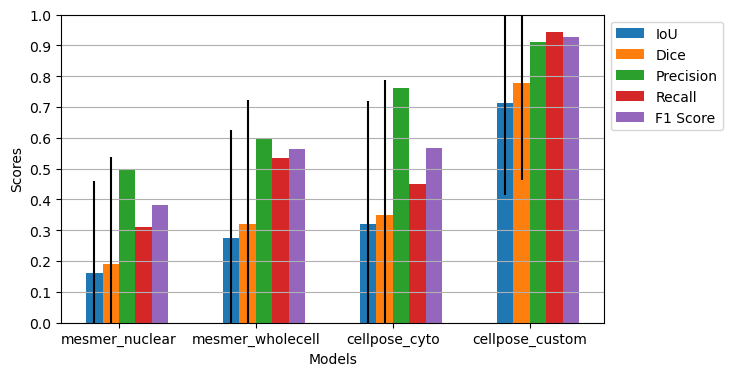

In [8]:
import matplotlib.pyplot as plt
# create plot with error bars for 4 groups: all_iou_total where all_dice_total[0] denotes mesmer_nuclear model, 1 for mesmer_wholecell, 2 for cellpose_cyto, 3 for cellpose_custom
# calculate mean and standard deviation for each group
mean_iou = [np.mean(all_iou_total[0]), np.mean(all_iou_total[1]), np.mean(all_iou_total[2]), np.mean(all_iou_total[3])]
std_iou = [np.std(all_iou_total[0]), np.std(all_iou_total[1]), np.std(all_iou_total[2]), np.std(all_iou_total[3])]
# get standard error

mean_dice = [np.mean(all_dice_total[0]), np.mean(all_dice_total[1]), np.mean(all_dice_total[2]), np.mean(all_dice_total[3])]
std_dice = [np.std(all_dice_total[0]), np.std(all_dice_total[1]), np.std(all_dice_total[2]), np.std(all_dice_total[3])]
precision = [results_df.precision.values[0], results_df.precision.values[1], results_df.precision.values[2], results_df.precision.values[3]]
recall = [results_df.recall.values[0], results_df.recall.values[1], results_df.recall.values[2], results_df.recall.values[3]]
f1_score = [results_df.f1_score.values[0], results_df.f1_score.values[1], results_df.f1_score.values[2], results_df.f1_score.values[3]]

x = np.arange(len(models))

fig, ax = plt.subplots()
# make figzie bigger
fig.set_size_inches(7, 4)
# add dice score with offset (per bar, should be left side iou, right side dice)
bar_width = 0.12
ax.bar(x, mean_iou, bar_width, yerr=std_iou, label='IoU')
ax.bar(x + bar_width, mean_dice, bar_width, yerr=std_dice, label='Dice')
ax.bar(x + bar_width*2, precision, bar_width, label='Precision')
ax.bar(x + bar_width*3, recall, bar_width, label='Recall')
ax.bar(x + bar_width*4, f1_score, bar_width, label='F1 Score')
ax.set_xlabel('Models')

ax.set_ylabel('Scores')
ax.set_xticks(x)
# move x ticks by 2 bar widths to the right
ax.set_xticks(x + bar_width*1.5)
ax.set_xticklabels(models)
ax.set_title
ax.yaxis.grid(True)
# cap 1 axis at 1
ax.set_ylim(0, 1)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
# put legend left
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
# save plot
fig.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/segmentation_evaluation_results.png', bbox_inches='tight')

In [9]:
results_df.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/segmentation_evaluation_results.csv', index=False)

### Use this to create segmentation evaluation metrics without 0 for oversegmentation and undersegmentation cases - precision, recall and F1 score take into account the FPs and FNs, and iou and dice only take into account the segmentation quality itself.

In [11]:
GT_dir = '/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/data/annotations'
models = ['mesmer_nuclear', 'mesmer_wholecell', 'cellpose_cyto', 'cellpose_custom']
segmentation_dir = '/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/data/segmentation/'

seg_eval_metrics = {
        "sample":[],
        "cropID":[],
        "model":[],
        "mean_iou":[],
        "mean_dice":[],
        "precision":[],
        "recall":[],
        "f1_score":[],
        "gt_cells":[],
        "predicted_cells":[]
        }
seg_eval_metrics_df = pd.DataFrame(seg_eval_metrics)

# define sample list as all unique values in the GT_dir listdir when only looking at the string before the second underscore (the first should be included in the sample id)
samples = ["_".join((os.path.splitext(os.path.basename(file))[0].split('_')[0], os.path.splitext(os.path.basename(file))[0].split('_')[1])) for file in os.listdir(GT_dir)]
samples = list(set(samples))

GT_list = []
prediction_list = []
all_iou_total = []
all_dice_total = []
gt_cells = 0
pred_cells = 0

# create a pandas df with model, total_true_positives, total_false_positives, total_false_negatives, total_oversegmentation, total_undersegmentation, mean_iou_all_cells, mean_dice_all_cells, precision, recall, f1_score
results_df = pd.DataFrame(columns=['model', 'total_true_positives', 'total_false_positives', 'total_false_negatives', 'mean_iou_all_cells', 'mean_dice_all_cells', 'precision', 'recall', 'f1_score'])

for model in models:

    all_iou_scores = []
    all_dice_scores = []
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0
    gt_cells = 0
    pred_cells = 0

    for sample in samples:
        for cropID in range(1,10):
            # if the file does not exist, skip it
            if os.path.exists(f'{GT_dir}/{sample}_GT_crop{cropID}.tif'):
                # load the ground truth image
                GT_image = np.array(tifffile.imread(f'{GT_dir}/{sample}_GT_crop{cropID}.tif'))
                GT_list.append(GT_image)

                # define the segmentation tool and model
                seg_tool = model.split("_")[0]
                seg_model = model.split("_")[1]

                prediction = np.array(tifffile.imread(f'{segmentation_dir}/{seg_tool}_{sample}_{seg_model}_crop{cropID}.tif'))
                prediction_list.append(prediction)

    print(model)
    print(len(GT_list))
    crop_counter = 0
    # Loop through all crops
    for ground_truth, prediction in zip(GT_list, prediction_list):
        print(crop_counter)
        crop_counter+=1

        # Match the cells
        ground_truth_relabel, pred_relabel, TTP, FP, FN = cell_matching(ground_truth, prediction, overlap_threshold=0.5)
        print(TTP, FP, FN)
    
        unique_gt_labels = np.unique(ground_truth_relabel)

        unique_pred_labels = np.unique(pred_relabel)
        if 0 in unique_gt_labels:
            unique_gt_labels = unique_gt_labels[1:]
        if 0 in unique_pred_labels:
            unique_pred_labels = unique_pred_labels[1:]

        gt_labels = unique_gt_labels
        gt_all_labels = np.unique(ground_truth)
        if 0 in gt_all_labels:
            gt_all_labels = gt_all_labels[1:]

        pred_labels = unique_pred_labels
        pred_all_labels = np.unique(prediction)
        if 0 in pred_all_labels:
            pred_all_labels = pred_all_labels[1:]

        pred_cells += len(pred_all_labels)
        gt_cells += len(gt_all_labels)

        for label in gt_labels:
            gt_binary = ground_truth_relabel == label
            pred_binary = pred_relabel == label
            
            # Compute Intersection over Union (IoU)
            intersection = np.logical_and(gt_binary, pred_binary).sum()
            union = np.logical_or(gt_binary, pred_binary).sum()
            iou = intersection / union if union != 0 else 0
            all_iou_scores.append(iou)

            # Compute Dice Coefficient
            dice = (2 * intersection) / (gt_binary.sum() + pred_binary.sum()) if (gt_binary.sum() + pred_binary.sum()) != 0 else 0
            all_dice_scores.append(dice)

        # Accumulate true positives, false positives and false negatives
        total_true_positives += TTP
        total_false_positives += FP
        total_false_negatives += FN

    # Mean IoU and Dice over all cells
    mean_iou_all_cells = np.mean(all_iou_scores) if all_iou_scores else 0
    mean_dice_all_cells = np.mean(all_dice_scores) if all_dice_scores else 0
    
    # Precision and Recall
    precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    
    # F1-Score (Harmonic mean of Precision and Recall)
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
    results_df = pd.concat([results_df, pd.DataFrame({
        'model': [model],
        'total_true_positives': [total_true_positives],
        'total_false_positives': [total_false_positives],
        'total_false_negatives': [total_false_negatives],
        'mean_iou_all_cells': [mean_iou_all_cells],
        'mean_dice_all_cells': [mean_dice_all_cells],
        'precision': [precision],
        'recall': [recall],
        'f1_score': [f1_score],
        'GT_cells': [gt_cells],
        'predicted_cells': [pred_cells]
    })])
    all_iou_total.append(all_iou_scores)
    all_dice_total.append(all_dice_scores)
    GT_list = []
    prediction_list = []

    print(f'model {model} processed')

results_df['total_cells'] = results_df['total_true_positives'] + results_df['total_false_positives'] + results_df['total_false_negatives']
results_df['sum_of_TTP_FN'] = results_df['total_true_positives'] + results_df['total_false_negatives']
results_df['sum_of_TTP_FP'] = results_df['total_true_positives'] + results_df['total_false_positives']
results_df.reset_index(drop=True, inplace=True)

mesmer_nuclear
16
0


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
36 17 66
1


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
22 25 38
2


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
24 19 59
3


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
23 36 89
4


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
29 26 57
5


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
25 26 52
6


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
26 16 28
7


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
27 22 53
8


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
24 24 63
9
TTP preds and TTP GTs is equal? True
10 22 27
10


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
25 24 53
11


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
12 27 39
12


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
22 28 60
13


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
22 20 46
14
TTP preds and TTP GTs is equal? True
23 22 54
15
TTP preds and TTP GTs is equal? True
23 26 51
model mesmer_nuclear processed
mesmer_wholecell
16
0


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/3300603699.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
62 26 40
1


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
32 23 28
2


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
38 28 45
3


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
32 48 80
4


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
51 28 35
5


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
57 26 20
6


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
25 16 29
7


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
51 28 29
8


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
40 28 47
9
TTP preds and TTP GTs is equal? True
12 26 25


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


10


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
40 29 38
11


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
27 30 24
12


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
46 30 36
13


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
46 21 22
14


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
48 25 29
15


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
38 25 36
model mesmer_wholecell processed
cellpose_cyto
16
0
TTP preds and TTP GTs is equal? True
42 11 60
1


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
7 33 53
2
TTP preds and TTP GTs is equal? True
22 7 61
3


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
28 12 84
4
TTP preds and TTP GTs is equal? True
54 5 32
5
TTP preds and TTP GTs is equal? True
50 2 27
6
TTP preds and TTP GTs is equal? True
9 17 45
7
TTP preds and TTP GTs is equal? True
50 9 30
8


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.pred_label == pred_label, 'pred_label'] = gt_for_group


TTP preds and TTP GTs is equal? True
54 7 33
9
TTP preds and TTP GTs is equal? True
7 27 30
10


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_879/1098650657.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addition_to_df.loc[addition_to_df.gt_label == gt_label, 'gt_label'] = pred_for_group


TTP preds and TTP GTs is equal? True
44 6 34
11
TTP preds and TTP GTs is equal? True
24 8 27
12
TTP preds and TTP GTs is equal? True
44 8 38
13
TTP preds and TTP GTs is equal? True
29 6 39
14
TTP preds and TTP GTs is equal? True
42 5 35
15
TTP preds and TTP GTs is equal? True
38 8 36
model cellpose_cyto processed
cellpose_custom
16
0
TTP preds and TTP GTs is equal? True
97 14 5
1
TTP preds and TTP GTs is equal? True
55 11 5
2
TTP preds and TTP GTs is equal? True
81 8 2
3
TTP preds and TTP GTs is equal? True
96 15 16
4
TTP preds and TTP GTs is equal? True
82 6 4
5
TTP preds and TTP GTs is equal? True
75 4 2
6
TTP preds and TTP GTs is equal? True
45 11 9
7
TTP preds and TTP GTs is equal? True
78 7 2
8
TTP preds and TTP GTs is equal? True
76 5 11
9
TTP preds and TTP GTs is equal? True
37 2 0
10
TTP preds and TTP GTs is equal? True
77 2 1
11
TTP preds and TTP GTs is equal? True
49 3 2
12
TTP preds and TTP GTs is equal? True
76 4 6
13
TTP preds and TTP GTs is equal? True
68 3 0
14
TTP preds

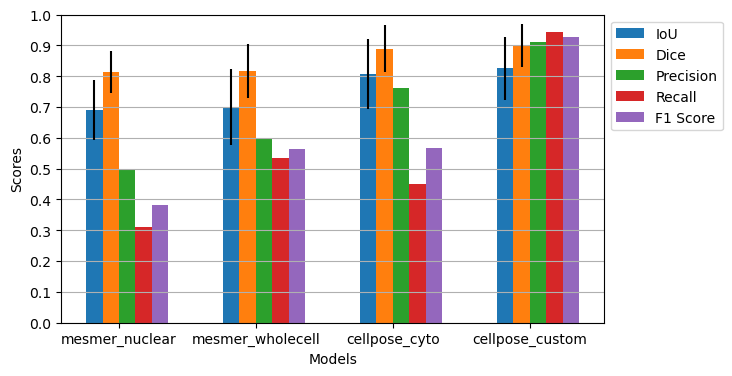

In [12]:
import matplotlib.pyplot as plt
mean_iou = [np.mean(all_iou_total[0]), np.mean(all_iou_total[1]), np.mean(all_iou_total[2]), np.mean(all_iou_total[3])]
std_iou = [np.std(all_iou_total[0]), np.std(all_iou_total[1]), np.std(all_iou_total[2]), np.std(all_iou_total[3])]

mean_dice = [np.mean(all_dice_total[0]), np.mean(all_dice_total[1]), np.mean(all_dice_total[2]), np.mean(all_dice_total[3])]
std_dice = [np.std(all_dice_total[0]), np.std(all_dice_total[1]), np.std(all_dice_total[2]), np.std(all_dice_total[3])]
precision = [results_df.precision.values[0], results_df.precision.values[1], results_df.precision.values[2], results_df.precision.values[3]]
recall = [results_df.recall.values[0], results_df.recall.values[1], results_df.recall.values[2], results_df.recall.values[3]]
f1_score = [results_df.f1_score.values[0], results_df.f1_score.values[1], results_df.f1_score.values[2], results_df.f1_score.values[3]]

x = np.arange(len(models))

fig, ax = plt.subplots()
fig.set_size_inches(7, 4)

bar_width = 0.12
ax.bar(x, mean_iou, bar_width, yerr=std_iou, label='IoU')
ax.bar(x + bar_width, mean_dice, bar_width, yerr=std_dice, label='Dice')
ax.bar(x + bar_width*2, precision, bar_width, label='Precision')
ax.bar(x + bar_width*3, recall, bar_width, label='Recall')
ax.bar(x + bar_width*4, f1_score, bar_width, label='F1 Score')
ax.set_xlabel('Models')

ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_xticks(x + bar_width*1.5)
ax.set_xticklabels(models)
ax.set_title
ax.yaxis.grid(True)
ax.set_ylim(0, 1)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

fig.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_evaluation_results_no0s.png', bbox_inches='tight')
fig.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_evaluation_results_no0s.svg', bbox_inches='tight')

In [13]:
results_df.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_evaluation_results_no0s.csv', index=False)

### Use this to create the ground truth annotation cell count dataframe

In [24]:
import tifffile
cell_counts_df = pd.DataFrame(np.zeros((4,4)), columns=['control', '4h', '24h', '48h'])
GT_dir = '/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/data/annotations'

samples = ["_".join((os.path.splitext(os.path.basename(file))[0].split('_')[0], os.path.splitext(os.path.basename(file))[0].split('_')[1])) for file in os.listdir(GT_dir)]
samples = list(set(samples))

for sample in samples:
    for cropID in range(1,10):
        # if the file does not exist, skip it
        if os.path.exists(f'{GT_dir}/{sample}_GT_crop{cropID}.tif'):
            # load the ground truth image
            sam = sample.split('_')[0]

            GT_image = np.array(tifffile.imread(f'{GT_dir}/{sample}_GT_crop{cropID}.tif'))
            cell_number = len(set(np.unique(GT_image)) - {0})
            cell_counts_df[sam][cropID-1] = cell_number
cell_counts_df.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/cell_counts_GT_annotation.csv', index=False)

### Use this to test cell matching on specific crops

In [410]:
GT_dir = '/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/data/annotations'
models = ['mesmer_nuclear', 'mesmer_wholecell', 'cellpose_cyto', 'cellpose_custom']
segmentation_dir = '/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/data/segmentation'

# define sample list as all unique values in the GT_dir listdir when only looking at the string before the second underscore (the first should be included in the sample id)
samples = ["_".join((os.path.splitext(os.path.basename(file))[0].split('_')[0], os.path.splitext(os.path.basename(file))[0].split('_')[1])) for file in os.listdir(GT_dir)]
samples = list(set(samples))

all_iou_total = []
all_dice_total = []

sample = '24h_83'
model = 'cellpose_custom'
cropID = 3

ground_truth = np.array(tifffile.imread(f'{GT_dir}/{sample}_GT_crop{cropID}.tif'))
print(ground_truth)

# define the segmentation tool and model
seg_tool = model.split("_")[0]
seg_model = model.split("_")[1]

prediction = np.array(tifffile.imread(f'{segmentation_dir}/{seg_tool}_{sample}_{seg_model}_crop{cropID}.tif'))
print(prediction)
print(model, sample, cropID)
# Loop through all crops

# Match the cells
ground_truth_relabel, pred_relabel, TTP, FP, FN = cell_matching(ground_truth, prediction, overlap_threshold=0.5)

[[ 0  0  0 ... 80 80 80]
 [ 0  0  0 ... 80 80 80]
 [ 0  0  0 ... 80 80 80]
 ...
 [26 26 26 ... 83 83 83]
 [26 26 26 ... 83 83 83]
 [26 26 26 ... 83 83 83]]
[[47051 47051 47051 ... 47300 47300 47300]
 [47051 47051 47051 ... 47300 47300 47300]
 [47051 47051 47051 ... 47300 47300 47300]
 ...
 [48816 48816 48816 ... 48829 48829 48829]
 [48816 48816 48816 ... 48829 48829 48829]
 [48816 48816 48816 ... 48829 48829 48829]]
cellpose_custom 24h_83 3
TTP preds and TTP GTs is equal? True
81 8 2


## Below is the code for phenotyping evaluation based on ground truth data

Reads in the data per crop containing the `GT_cell_type` column denoting the ground truth label. 
and the `cell_meta_cluster` column denoting the predicted label column using Pixie.
Subsets dataframe to the relevant columns, and prints accuracy, precision, 
recall, f1 score metrics, as well as plots a confusion matrix.

In [44]:
import glob
import pandas as pd

csv_path = '/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/phenotyping/*.csv'
csv_files = glob.glob(csv_path)

dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)
all_crops_df = pd.concat(dataframes, ignore_index=True)

keep_cols = ['GT_cell_type', 'cell_meta_cluster']
all_crops_df = all_crops_df[keep_cols]

In [45]:
# exclude all rows with classes that appear less than 10 times
min_threshold = 5
value_counts = all_crops_df['GT_cell_type'].value_counts()
to_exclude = value_counts[value_counts < min_threshold].index
all_crops_df = all_crops_df[~all_crops_df['GT_cell_type'].isin(to_exclude)]
all_crops_df = all_crops_df[~all_crops_df['cell_meta_cluster'].isin(to_exclude)]

Total cell count: 1214
Accuracy: 0.94
Precision: 0.95
Recall: 0.94
F1 Score: 0.94
Per Class Precision: [0.93149038 0.96319018 0.97014925 1.         0.88888889 1.        ]
Per Class Recall: [1.         1.         0.72222222 0.8125     0.76190476 0.88235294]
Per Class F1 Score: [0.96453018 0.98125    0.82802548 0.89655172 0.82051282 0.9375    ]


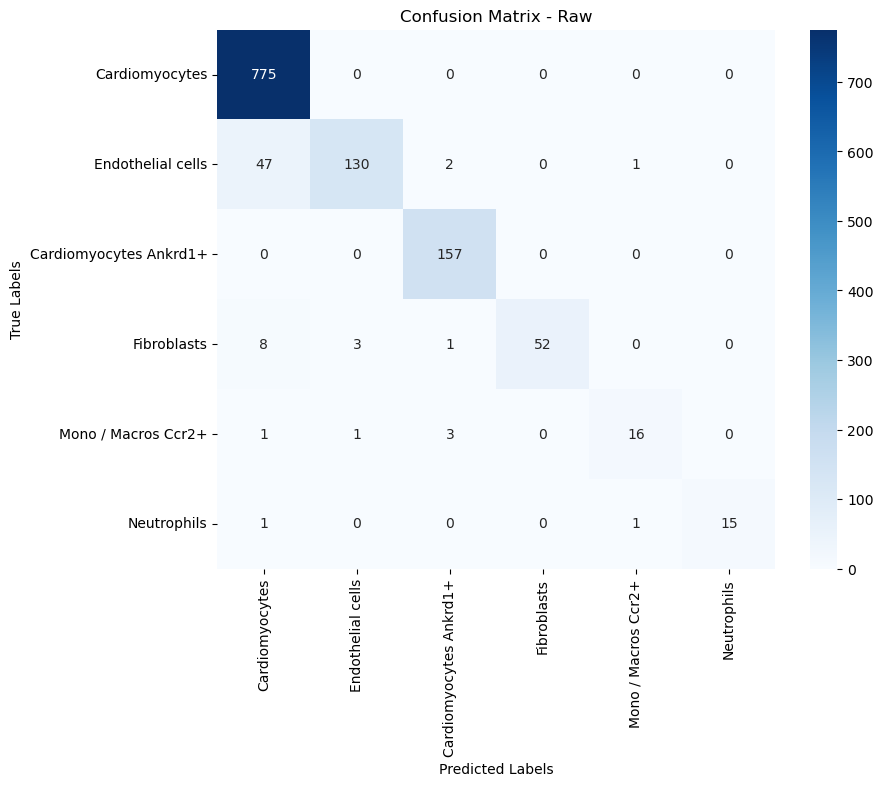

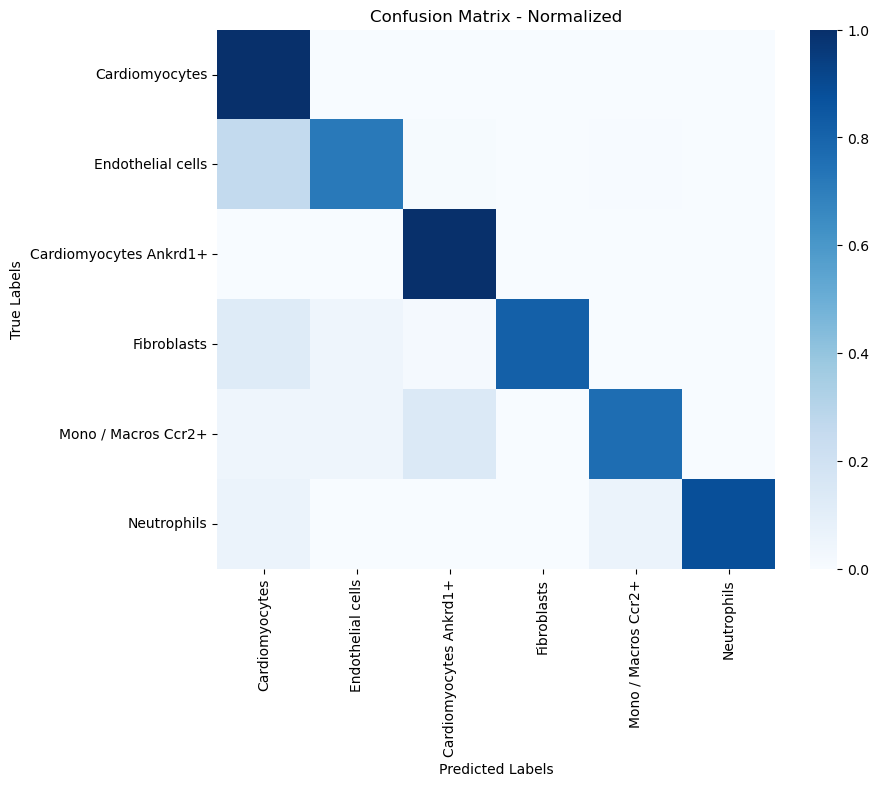

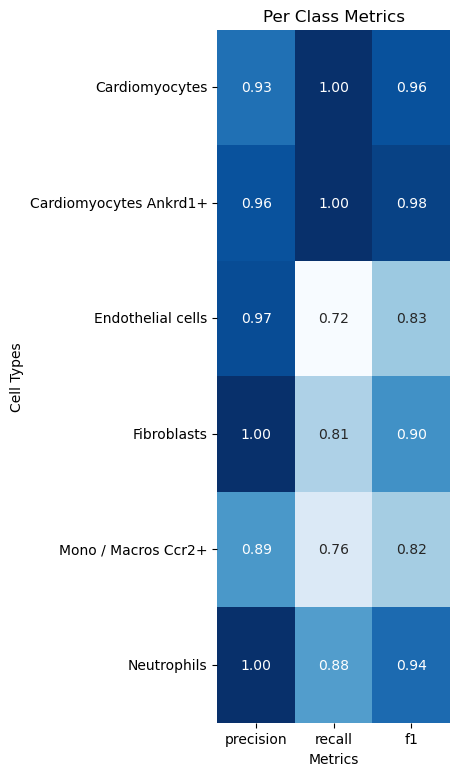

In [53]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

min_threshold = 10
df = all_crops_df.copy()

value_counts = df['GT_cell_type'].value_counts()
to_exclude = value_counts[value_counts < min_threshold].index

df = df[~df['GT_cell_type'].isin(to_exclude)]
df = df[~df['cell_meta_cluster'].isin(to_exclude)]

# Calculate evaluation metrics
accuracy = accuracy_score(df['GT_cell_type'], df['cell_meta_cluster'])
precision = precision_score(df['GT_cell_type'], df['cell_meta_cluster'], average='weighted')
recall = recall_score(df['GT_cell_type'], df['cell_meta_cluster'], average='weighted')
f1 = f1_score(df['GT_cell_type'], df['cell_meta_cluster'], average='weighted')

# calculate per class precision, recall and f1
per_class_precision = precision_score(df['GT_cell_type'], df['cell_meta_cluster'], average=None)
per_class_recall = recall_score(df['GT_cell_type'], df['cell_meta_cluster'], average=None)
per_class_f1 = f1_score(df['GT_cell_type'], df['cell_meta_cluster'], average=None)

# Print the metrics
print(f"Total cell count: {df.shape[0]}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Per Class Precision: {per_class_precision}")
print(f"Per Class Recall: {per_class_recall}")
print(f"Per Class F1 Score: {per_class_f1}")

conf_matrix = confusion_matrix(df['GT_cell_type'], df['cell_meta_cluster'], labels=df.GT_cell_type.value_counts().index)

# Visualize the confusion matrix using Seaborn heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=df.GT_cell_type.value_counts().index, 
            yticklabels=df.GT_cell_type.value_counts().index)

plt.title('Confusion Matrix - Raw')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/confusion_matrix_raw.png', bbox_inches='tight')
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/confusion_matrix_raw.svg', bbox_inches='tight')
plt.show()

conf_matrix_norm = confusion_matrix(df['GT_cell_type'], df['cell_meta_cluster'], normalize='true', labels=df.GT_cell_type.value_counts().index)

plt.figure(figsize=(9, 7))
sns.heatmap(conf_matrix_norm,fmt='d', cmap='Blues', 
            xticklabels=df.GT_cell_type.value_counts().index, 
            yticklabels=df.GT_cell_type.value_counts().index)

plt.title('Confusion Matrix - Normalized')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/confusion_matrix_normalized.png', bbox_inches='tight')
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/confusion_matrix_normalized.svg', bbox_inches='tight')
plt.show()

# create heatmap per class (in columns) with the per-class recall, per-class precision and per-class f1 in rows
per_class_metrics = pd.DataFrame({'precision': per_class_precision, 'recall': per_class_recall, 'f1': per_class_f1})
plt.figure(figsize=(3, 9))
# make the heatmap boxes as thin as possible
sns.heatmap(per_class_metrics, annot=True, fmt='.2f', cmap='Blues', 
            yticklabels=unique_labels(df['GT_cell_type'], df['cell_meta_cluster']), 
            xticklabels=['precision', 'recall', 'f1'], cbar=False)

plt.title('Per Class Metrics')
plt.xlabel('Metrics')
plt.ylabel('Cell Types')
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/per_class_metrics.png', bbox_inches='tight')
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/per_class_metrics.svg', bbox_inches='tight')
plt.show()

### Below is the code needed to create the plots for the Supplementary Figure 6

In [162]:
from skimage import exposure, measure, segmentation
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


GT_dir = '/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/data/annotations'
models = ['mesmer_nuclear', 'mesmer_wholecell', 'cellpose_cyto', 'cellpose_custom']
segmentation_dir = '/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/data/segmentation'
image_dir = '/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/crops_DAPI_WGA'
samples = ["_".join((os.path.splitext(os.path.basename(file))[0].split('_')[0], os.path.splitext(os.path.basename(file))[0].split('_')[1])) for file in os.listdir(GT_dir)]
samples = list(set(samples))
samples = [sample for sample in samples if sample != '.DS_Store']

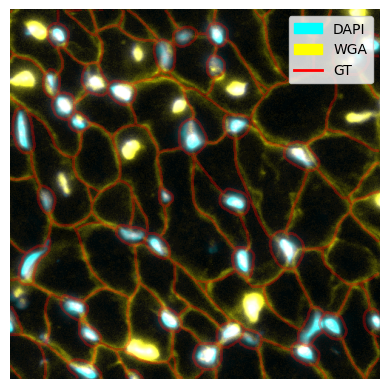

In [164]:
sample = '24h_83'
cropID = 1
image = np.array(tifffile.imread(f'{image_dir}/clahe_{sample}_crop{cropID}.tif'))
GT_segmentation = np.array(tifffile.imread(f'{GT_dir}/{sample}_GT_crop{cropID}.tif'))

DAPI_scaling_factor = 1.5
WGA_scaling_factor = 3

DAPI = exposure.rescale_intensity(image[0], out_range=(0, 255*DAPI_scaling_factor))
DAPI[DAPI > 255] = 255
DAPI = DAPI.astype(np.uint8)

WGA = exposure.rescale_intensity(image[1], out_range=(0, 255*WGA_scaling_factor))
WGA[WGA > 255] = 255
WGA = WGA.astype(np.uint8)

# Create an empty RGB image
rgb_image = np.zeros((DAPI.shape[0], DAPI.shape[1], 3), dtype=np.uint8)

# Map the first channel to cyan (green + blue)
rgb_image[..., 1] = DAPI  # Green
rgb_image[..., 2] = DAPI  # Blue

# Map the second channel to yellow (red + green)
rgb_image[..., 0] = WGA  # Red
rgb_image[..., 1] = np.maximum(rgb_image[..., 1], WGA)  # Ensure yellow is dominant

# get contours of the GT_segmentation and set them all to the same value
GT_segmentation = GT_segmentation.astype(np.uint8)
boundaries = segmentation.find_boundaries(GT_segmentation, mode='outer')
plt.contour(boundaries, colors='red', linewidths=1, alpha=0.3)  # Uniform contour intensity

# Custom legend patches
cyan_patch = mpatches.Patch(color='cyan', label='DAPI')
yellow_patch = mpatches.Patch(color='yellow', label='WGA')
red_line = mlines.Line2D([], [], color='red', label='GT', linewidth=2)

# Add the custom legend
plt.legend(handles=[cyan_patch, yellow_patch, red_line], loc='upper right')

# Plot the result
plt.imshow(rgb_image)
plt.axis('off')

plt.savefig("/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_images/GT_raw.png", dpi=300, bbox_inches='tight')
plt.savefig("/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_images/GT_raw.svg", bbox_inches='tight')

plt.show()


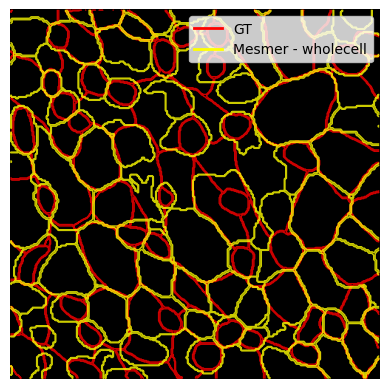

In [176]:
sample = '24h_83'
cropID = 1
model = 'mesmer_wholecell'

seg_tool = model.split('_')[0]
seg_model = model.split('_')[1]

image = np.array(tifffile.imread(f'{image_dir}/clahe_{sample}_crop{cropID}.tif'))
GT_segmentation = np.array(tifffile.imread(f'{GT_dir}/{sample}_GT_crop{cropID}.tif'))
prediction_segmentation = np.array(tifffile.imread(f'{segmentation_dir}/{seg_tool}_{sample}_{seg_model}_crop{cropID}.tif'))
rgb_image = np.zeros((image[0].shape[0], image[0].shape[1], 3), dtype=np.uint8)

# get contours of the GT_segmentation and set them all to the same value
GT_segmentation = GT_segmentation.astype(np.uint8)
boundaries = segmentation.find_boundaries(GT_segmentation, mode='outer')
plt.contour(boundaries, colors='red', linewidths=1, alpha=0.8)  # Uniform contour intensity

prediction_segmentation = prediction_segmentation.astype(np.uint8)
boundaries_prediction = segmentation.find_boundaries(prediction_segmentation, mode='outer')
plt.contour(boundaries_prediction, colors='yellow', linewidths=1, alpha=0.8)  # Uniform contour intensity

# Custom legend patches
red_line = mlines.Line2D([], [], color='red', label='GT', linewidth=2)
lime_line = mlines.Line2D([], [], color='yellow', label=f'{seg_tool.capitalize()} - {seg_model}', linewidth=2)

# Add the custom legend
plt.legend(handles=[red_line, lime_line], loc='upper right')
plt.imshow(rgb_image)
plt.axis('off')

plt.savefig("/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_images/mesmer_wholecell.png", dpi=300, bbox_inches='tight')
plt.savefig("/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_images/mesmer_wholecell.svg", bbox_inches='tight')

plt.show()


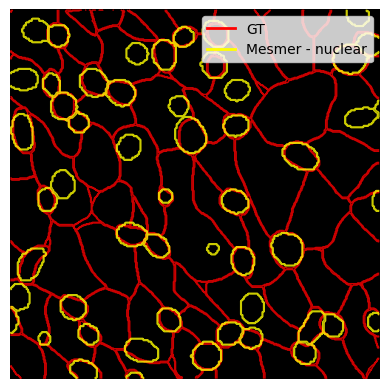

In [175]:
sample = '24h_83'
cropID = 1
model = 'mesmer_nuclear'

seg_tool = model.split('_')[0]
seg_model = model.split('_')[1]

image = np.array(tifffile.imread(f'{image_dir}/clahe_{sample}_crop{cropID}.tif'))
GT_segmentation = np.array(tifffile.imread(f'{GT_dir}/{sample}_GT_crop{cropID}.tif'))
prediction_segmentation = np.array(tifffile.imread(f'{segmentation_dir}/{seg_tool}_{sample}_{seg_model}_crop{cropID}.tif'))
rgb_image = np.zeros((image[0].shape[0], image[0].shape[1], 3), dtype=np.uint8)

# get contours of the GT_segmentation and set them all to the same value
GT_segmentation = GT_segmentation.astype(np.uint8)
boundaries = segmentation.find_boundaries(GT_segmentation, mode='outer')
plt.contour(boundaries, colors='red', linewidths=1, alpha=0.8)  # Uniform contour intensity

prediction_segmentation = prediction_segmentation.astype(np.uint8)
boundaries_prediction = segmentation.find_boundaries(prediction_segmentation, mode='outer')
plt.contour(boundaries_prediction, colors='yellow', linewidths=1, alpha=0.8)  # Uniform contour intensity

# Custom legend patches
red_line = mlines.Line2D([], [], color='red', label='GT', linewidth=2)
lime_line = mlines.Line2D([], [], color='yellow', label=f'{seg_tool.capitalize()} - {seg_model}', linewidth=2)

# Add the custom legend
plt.legend(handles=[red_line, lime_line], loc='upper right')
plt.imshow(rgb_image)
plt.axis('off')

plt.savefig(f"/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_images/{model}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_images/{model}.svg", bbox_inches='tight')

plt.show()


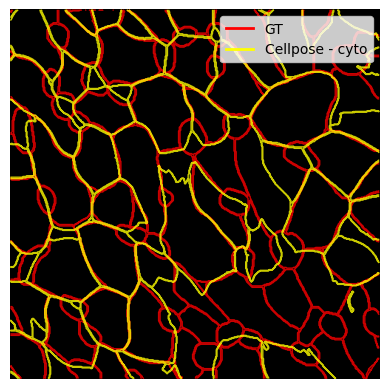

In [177]:
sample = '24h_83'
cropID = 1
model = 'cellpose_cyto'

seg_tool = model.split('_')[0]
seg_model = model.split('_')[1]

image = np.array(tifffile.imread(f'{image_dir}/clahe_{sample}_crop{cropID}.tif'))
GT_segmentation = np.array(tifffile.imread(f'{GT_dir}/{sample}_GT_crop{cropID}.tif'))
prediction_segmentation = np.array(tifffile.imread(f'{segmentation_dir}/{seg_tool}_{sample}_{seg_model}_crop{cropID}.tif'))
rgb_image = np.zeros((image[0].shape[0], image[0].shape[1], 3), dtype=np.uint8)

# get contours of the GT_segmentation and set them all to the same value
GT_segmentation = GT_segmentation.astype(np.uint8)
boundaries = segmentation.find_boundaries(GT_segmentation, mode='outer')
plt.contour(boundaries, colors='red', linewidths=1, alpha=0.8)  # Uniform contour intensity

prediction_segmentation = prediction_segmentation.astype(np.uint8)
boundaries_prediction = segmentation.find_boundaries(prediction_segmentation, mode='outer')
plt.contour(boundaries_prediction, colors='yellow', linewidths=1, alpha=0.8)  # Uniform contour intensity

# Custom legend patches
red_line = mlines.Line2D([], [], color='red', label='GT', linewidth=2)
lime_line = mlines.Line2D([], [], color='yellow', label=f'{seg_tool.capitalize()} - {seg_model}', linewidth=2)

# Add the custom legend
plt.legend(handles=[red_line, lime_line], loc='upper right')
plt.imshow(rgb_image)
plt.axis('off')

plt.savefig(f"/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_images/{model}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_images/{model}.svg", bbox_inches='tight')

plt.show()


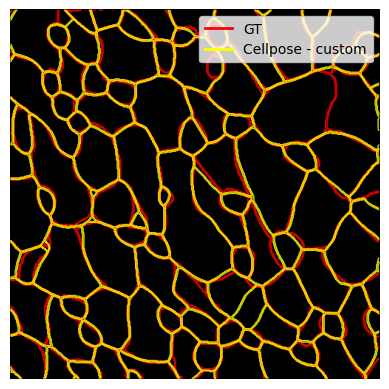

In [178]:
sample = '24h_83'
cropID = 1
model = 'cellpose_custom'

seg_tool = model.split('_')[0]
seg_model = model.split('_')[1]

image = np.array(tifffile.imread(f'{image_dir}/clahe_{sample}_crop{cropID}.tif'))
GT_segmentation = np.array(tifffile.imread(f'{GT_dir}/{sample}_GT_crop{cropID}.tif'))
prediction_segmentation = np.array(tifffile.imread(f'{segmentation_dir}/{seg_tool}_{sample}_{seg_model}_crop{cropID}.tif'))
rgb_image = np.zeros((image[0].shape[0], image[0].shape[1], 3), dtype=np.uint8)

# get contours of the GT_segmentation and set them all to the same value
GT_segmentation = GT_segmentation.astype(np.uint8)
boundaries = segmentation.find_boundaries(GT_segmentation, mode='outer')
plt.contour(boundaries, colors='red', linewidths=1, alpha=0.8)  # Uniform contour intensity

prediction_segmentation = prediction_segmentation.astype(np.uint8)
boundaries_prediction = segmentation.find_boundaries(prediction_segmentation, mode='outer')
plt.contour(boundaries_prediction, colors='yellow', linewidths=1, alpha=0.8)  # Uniform contour intensity

# Custom legend patches
red_line = mlines.Line2D([], [], color='red', label='GT', linewidth=2)
lime_line = mlines.Line2D([], [], color='yellow', label=f'{seg_tool.capitalize()} - {seg_model}', linewidth=2)

# Add the custom legend
plt.legend(handles=[red_line, lime_line], loc='upper right')
plt.imshow(rgb_image)
plt.axis('off')

plt.savefig(f"/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_images/{model}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/segmentation_evaluation/plots/segmentation_images/{model}.svg", bbox_inches='tight')

plt.show()
